In [ ]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath("../.."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [3]:
## Load Data

x_train = np.load('../../data/images/train_no_aug_time_norm.npy') 
y_train = np.load('../../data/labels/train_labels.npy')  
x_test = np.load('../../data/images/test_time_norm.npy')
y_test = np.load('../../data/labels/test_labels.npy')

## 0% time point

In [36]:
## Load models
time_point = 0 #20%
x_train_0 = x_train[:, time_point, :, :]
x_test_0 = x_test[:, time_point, :, :]
y_train_0 = y_train
y_test_0 = y_test

config = {
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
}

img_shape = (x_train_0.shape[1], x_train_0.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
encoder.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon8/models/encoder.weights.h5") ###TODO: change to the model path
decoder.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon8/models/decoder.weights.h5") ###TODO: change to the model path


In [39]:
latent_space_0 = encoder.predict(x_train_0)
cor_vals_0 = [np.corrcoef(np.eye(2)[y_train_0][:, 0], latent_space_0[:, i])[0, 1] for i in range(latent_space_0.shape[1])]
cor_vals_0 = np.array(cor_vals_0)
print(cor_vals_0)
most_correlated_feat, least_correlated_feat = np.argsort(np.abs(cor_vals_0))[-2:]
print("Most correlated feature: ", most_correlated_feat)
print("Least correlated feature: ", least_correlated_feat)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[-0.27407404 -0.23598483]
Most correlated feature:  1
Least correlated feature:  0


## 20% time point

In [105]:
## Load models
time_point = 2 #20%
x_train_20 = x_train[:, time_point, :, :]
x_test_20 = x_test[:, time_point, :, :]
y_train_20 = y_train
y_test_20 = y_test

config = {
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
}

img_shape = (x_train_20.shape[1], x_train_20.shape[2], 1)
encoder_20 = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder_20 = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
encoder_20.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/temporal_study_tps2_s1_ep35_lr5_la1_seed43_ldim2_s2_lr6_la4_lc1_lcon8/models/encoder.weights.h5") ###TODO: change to the model path
decoder_20.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/temporal_study_tps2_s1_ep35_lr5_la1_seed43_ldim2_s2_lr6_la4_lc1_lcon8/models/decoder.weights.h5") ###TODO: change to the model path


In [106]:
latent_space_20 = encoder_20.predict(x_train_20)
cor_vals_20 = [np.corrcoef(np.eye(2)[y_train_20][:, 0], latent_space_20[:, i])[0, 1] for i in range(latent_space_20.shape[1])]
cor_vals_20 = np.array(cor_vals_20)
print(cor_vals_20)
most_correlated_feat, least_correlated_feat = np.argsort(np.abs(cor_vals_20))[-2:]
print("Most correlated feature: ", most_correlated_feat)
print("Least correlated feature: ", least_correlated_feat)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[-0.25181452  0.29989972]
Most correlated feature:  0
Least correlated feature:  1


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


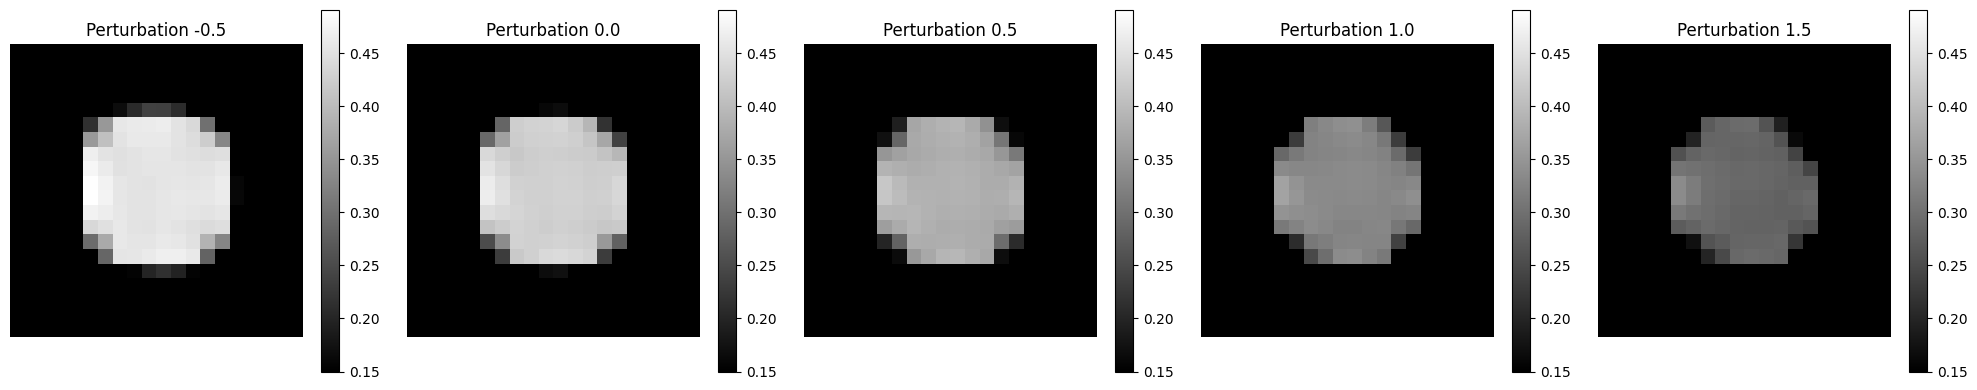

In [63]:
# Feature 0 - Size; Feature 1 - FRET

baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 1

# Perturbation range
#perturbations = np.linspace(-2, 2, 5) # feature index 0
perturbations = np.linspace(-0.5, 1.5, 5) # feature index 1

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder_20.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.15, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
#plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


## 50% time point

In [86]:
## Load models
time_point = 5 #50%
x_train_50 = x_train[:, time_point, :, :]
x_test_50 = x_test[:, time_point, :, :]
y_train_50 = y_train
y_test_50 = y_test

config = {
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
}

img_shape = (x_train_50.shape[1], x_train_50.shape[2], 1)
encoder_50 = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder_50 = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
encoder_50.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/temporal_study_tps5_s1_ep35_lr5_la1_seed43_ldim2_s2_lr6_la4_lc1_lcon8/models/encoder.weights.h5") ###TODO: change to the model path
decoder_50.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/temporal_study_tps5_s1_ep35_lr5_la1_seed43_ldim2_s2_lr6_la4_lc1_lcon8/models/decoder.weights.h5") ###TODO: change to the model path


In [98]:
latent_space_50 = encoder_50.predict(x_train_50)
cor_vals_50 = [np.corrcoef(np.eye(2)[y_train_50][:, 0], latent_space_50[:, i])[0, 1] for i in range(latent_space_50.shape[1])]
cor_vals_50 = np.array(cor_vals_50)
most_correlated_feat, least_correlated_feat = np.argsort(np.abs(cor_vals_50))[-2:]
print(cor_vals_50)
print("Most correlated feature: ", most_correlated_feat)
print("Least correlated feature: ", least_correlated_feat)
#feat_0, feat_1 = np.argsort(np.abs(cor_vals))[-2:] 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[-0.3113021   0.21636072]
Most correlated feature:  1
Least correlated feature:  0


In [88]:
cor_vals

array([-0.3113021 ,  0.21636072])

(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


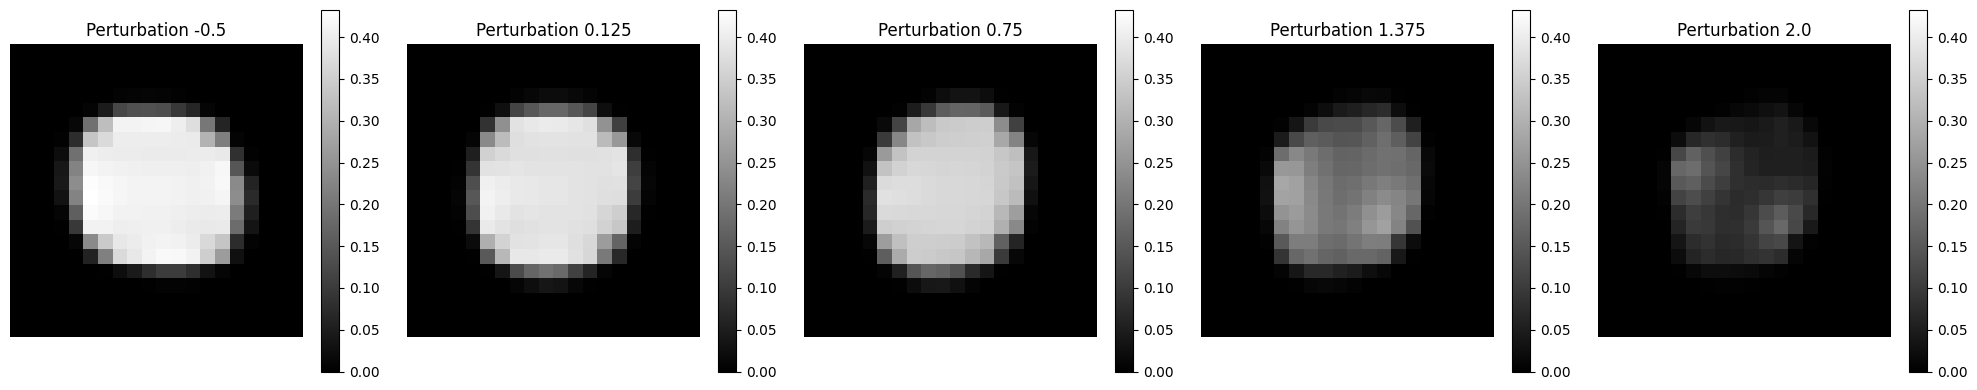

In [97]:
# Feature 0 - FRET; Feature 1 - Size

baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 0

# Perturbation range
#perturbations = np.linspace(-2, 2, 5) # feature index 1
perturbations = np.linspace(-0.5, 2, 5) # feature index 0

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder_50.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.0, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
#plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


## 80% cell time

In [101]:
## Load models
time_point = 8 #50%
x_train_80 = x_train[:, time_point, :, :]
x_test_80 = x_test[:, time_point, :, :]
y_train_80 = y_train
y_test_80 = y_test

config = {
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
}

img_shape = (x_train_80.shape[1], x_train_80.shape[2], 1)
encoder_80 = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder_80 = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
encoder_80.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/temporal_study_tps8_s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon8/models/encoder.weights.h5") ###TODO: change to the model path
decoder_80.load_weights("/Users/inescunha/Documents/GitHub/AI4CellFate/results/temporal_study_tps8_s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon8/models/decoder.weights.h5") ###TODO: change to the model path


In [102]:
latent_space_80 = encoder_80.predict(x_train_80)
cor_vals_80 = [np.corrcoef(np.eye(2)[y_train_80][:, 0], latent_space_80[:, i])[0, 1] for i in range(latent_space_50.shape[1])]
cor_vals_80 = np.array(cor_vals_80)
most_correlated_feat, least_correlated_feat = np.argsort(np.abs(cor_vals_80))[-2:]
print(cor_vals_80)
print("Most correlated feature: ", most_correlated_feat)
print("Least correlated feature: ", least_correlated_feat)
#feat_0, feat_1 = np.argsort(np.abs(cor_vals))[-2:] 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[-0.02260655  0.38135654]
Most correlated feature:  0
Least correlated feature:  1


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


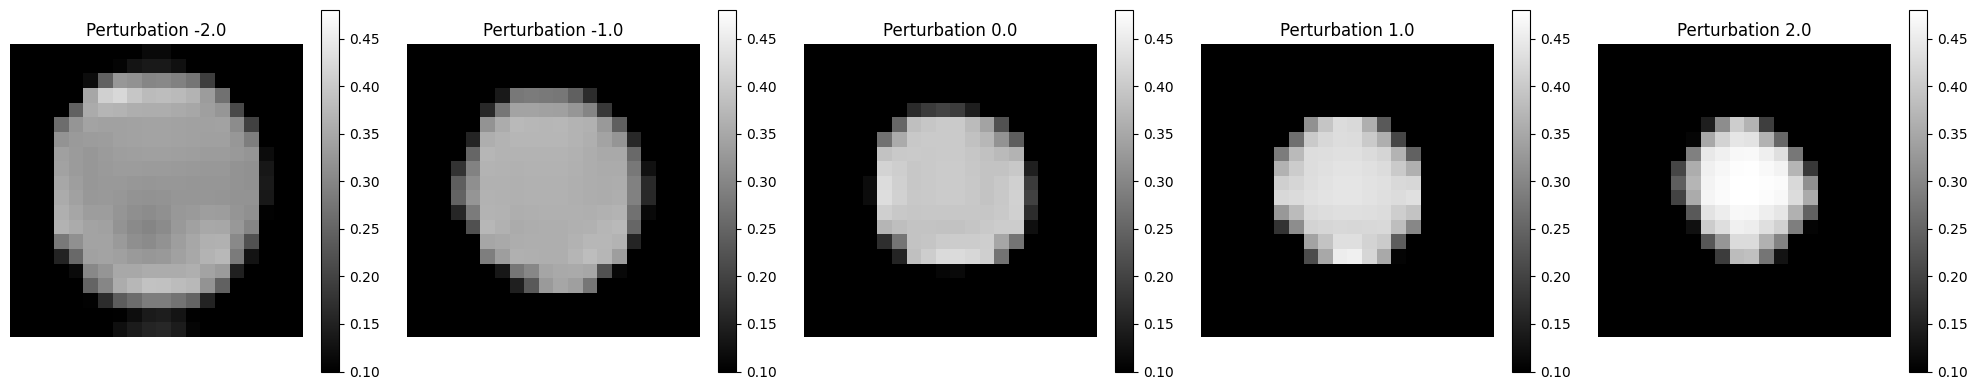

In [ ]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 1

# Perturbation range
#perturbations = np.linspace(-2, 2, 5) # feature index 1
perturbations = np.linspace(-2, 2, 5) # feature index 0

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder_80.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.1, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    #fig.colorbar(im, ax=axs[i])

plt.tight_layout()
#plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


# Bar plot with feature importance

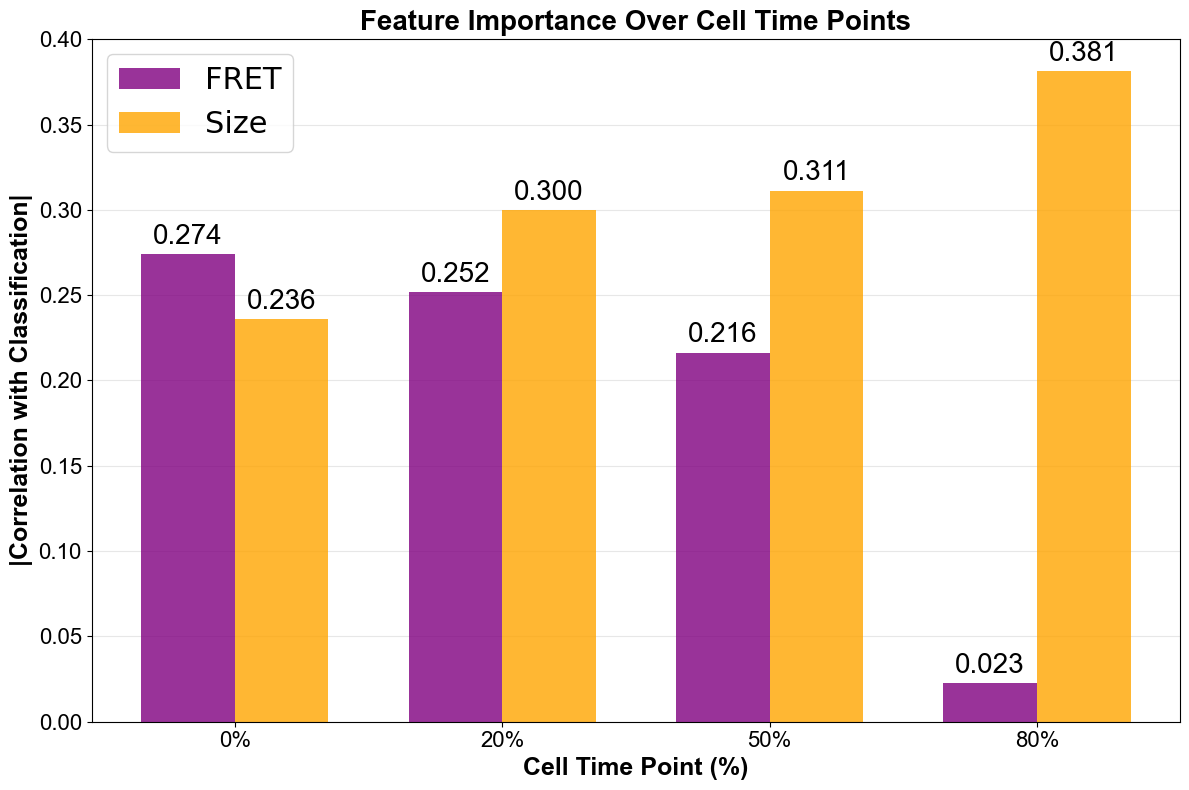

Correlation values:
Time point 0%: FRET = 0.2741, Size = 0.2360
  (Feature 0 = FRET: -0.2741, Feature 1 = Size: -0.2360)
Time point 20%: FRET = 0.2518, Size = 0.2999
  (Feature 0 = FRET: -0.2518, Feature 1 = Size: 0.2999)
Time point 50%: FRET = 0.2164, Size = 0.3113
  (Feature 0 = FRET: -0.3113, Feature 1 = Size: 0.2164)
Time point 80%: FRET = 0.0226, Size = 0.3814
  (Feature 0 = FRET: -0.0226, Feature 1 = Size: 0.3814)


In [116]:
# Bar plot showing feature importance over time points
import matplotlib.pyplot as plt
import numpy as np

# Time points and their corresponding correlation values
time_points = ['0%', '20%', '50%', '80%']
cor_values = [cor_vals_0, cor_vals_20, cor_vals_50, cor_vals_80]

# Define colors for each biological feature
fret_color = 'purple'#4472C4'  #  FRET
size_color =  'orange'#'#E91E63'  # Size

# Extract feature correlations and assign colors based on biological interpretation
feature_0_corr = [np.abs(cor_vals[0]) for cor_vals in cor_values]
feature_1_corr = [np.abs(cor_vals[1]) for cor_vals in cor_values]

# For each time point, determine which feature corresponds to FRET vs Size
# 0%: Feature 0 = FRET (most correlated), Feature 1 = Size
# 20%, 80%: Feature 1 = Size (highest value), Feature 0 = FRET  
# 50%: Feature 0 = Size (highest value), Feature 1 = FRET
fret_values = []
size_values = []

for i, tp in enumerate(time_points):
    if tp == '0%':
        # At 0%, Feature 0 is FRET (most correlated), Feature 1 is Size
        fret_values.append(feature_0_corr[i])
        size_values.append(feature_1_corr[i])
    elif tp == '50%':
        # At 50%, Feature 0 is Size (highest value), Feature 1 is FRET
        fret_values.append(feature_1_corr[i])
        size_values.append(feature_0_corr[i])
    else:
        # At 20% and 80%, Feature 1 is Size (highest value), Feature 0 is FRET
        fret_values.append(feature_0_corr[i])
        size_values.append(feature_1_corr[i])

# Set up the bar plot
x = np.arange(len(time_points))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Create bars for each biological feature with consistent colors
bars_fret = ax.bar(x - width/2, fret_values, width, label='FRET', color=fret_color, alpha=0.8)
bars_size = ax.bar(x + width/2, size_values, width, label='Size', color=size_color, alpha=0.8)

# Customize the plot with larger Arial fonts
ax.set_xlabel('Cell Time Point (%)', fontsize=18, fontweight='bold', fontname='Arial')
ax.set_ylabel('|Correlation with Classification|', fontsize=18, fontweight='bold', fontname='Arial')
ax.set_title('Feature Importance Over Cell Time Points', fontsize=20, fontweight='bold', fontname='Arial')
ax.set_xticks(x)
ax.set_xticklabels(time_points, fontsize=16, fontname='Arial')
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize=22)

# Set Arial font for y-tick labels
for label in ax.get_yticklabels():
    label.set_fontname('Arial')

# Add value labels on bars
for bar in bars_fret:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=20, fontname='Arial')

for bar in bars_size:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=20, fontname='Arial')

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Print the actual correlation values for reference
print("Correlation values:")
for i, tp in enumerate(time_points):
    print(f"Time point {tp}: FRET = {fret_values[i]:.4f}, Size = {size_values[i]:.4f}")
    if tp == '0%':
        print(f"  (Feature 0 = FRET: {cor_values[i][0]:.4f}, Feature 1 = Size: {cor_values[i][1]:.4f})")
    else:
        print(f"  (Feature 0 = FRET: {cor_values[i][0]:.4f}, Feature 1 = Size: {cor_values[i][1]:.4f})")


In [ ]:
## Time point 0: FRET is higher
## Time point 20: Size is higher
## Time point 50: Size is higher
## Time point 80: Size is higher